In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme()

In [12]:
def transform_columns(data):
    if "map_name" in data.columns:
        data["name"] = data["map_name"].str.split("\"").str[1]
        data["map type"] = data["name"]
    if "list_name" in data.columns:
        data["name"] = data["list_name"].str.split("\"").str[1]
        data["list type"] = data["name"]
    if "bucket_name" in data.columns:
        data["name"] = data["bucket_name"].str.split("\"").str[1]
        data["bucket type"] = data["name"]
    data["# threads"] = data["num_threads"]
    data["time_per_num_elements"] = data["time"] / data["num_elements"]
    data["time_per_num_queries"] = data["time"] / data["num_queries"]
    data["time_per_num_queries_and_num_elements"] = data["time"] / data["num_queries"] / data["num_elements"]
    data["log_time_per_num_queries_and_num_elements"] = np.log2(data["time_per_num_queries_and_num_elements"])
    data["log_num_elements"] = np.log2(data["num_elements"])
    return data

In [3]:
def get_data(pattern, directory="."):
    df = pd.concat(map(pd.read_csv, sorted(Path(directory).glob(pattern))), ignore_index=True)
    df = transform_columns(df)
    df.sort_values(by=["name"], inplace=True)
    return df

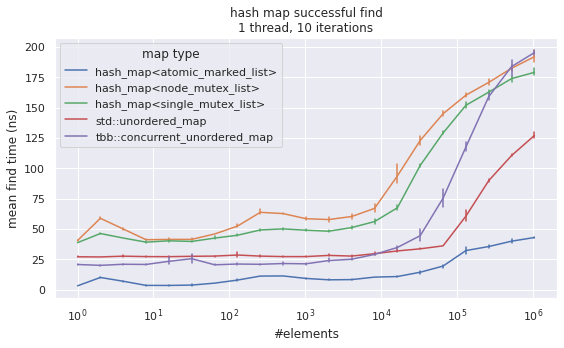

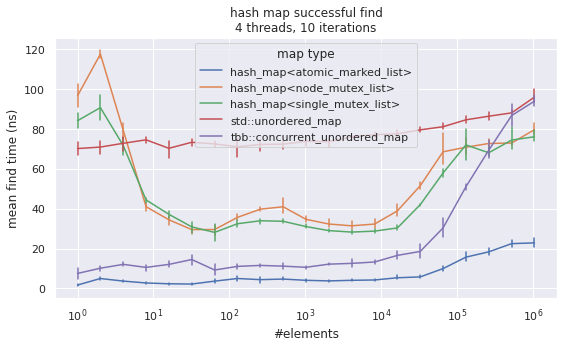

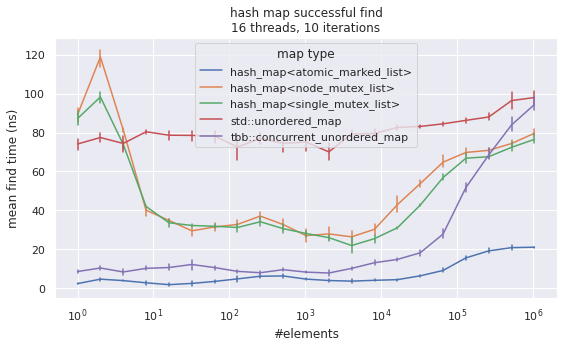

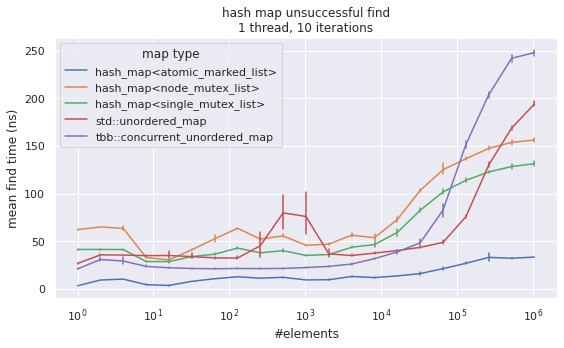

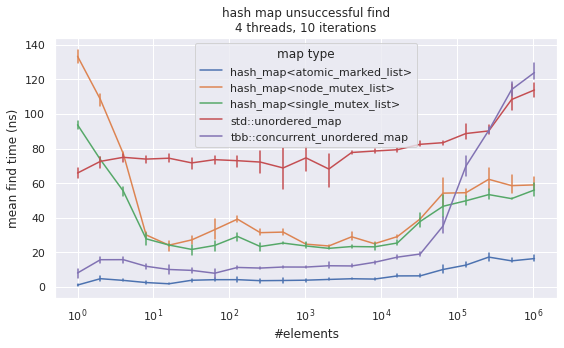

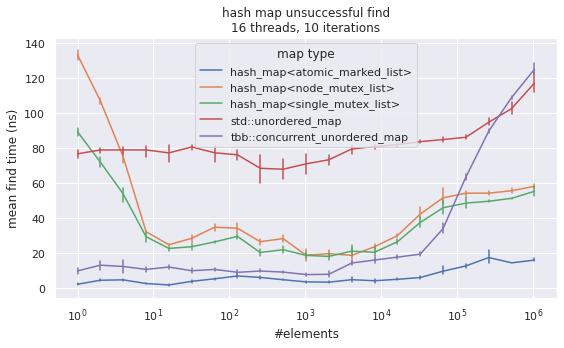

In [4]:
def plot_01(df, name):
    """
    hash map by #elements
    """
    num_iterations = df.groupby(["map_name", "num_elements", "num_queries", "num_threads"])["benchmark_name"].count()[0]
    for num_threads in (1, 4, 16):
        fig, ax = plt.subplots(figsize=(8, 5))
        
        sns.lineplot(data=df[df["num_threads"] == num_threads], x="num_elements", y="time_per_num_queries", hue="map type", err_style="bars")
        
        ax.set_title(f"{name}\n{num_threads} thread{'s' if num_threads > 1 else ''}, {num_iterations} iterations")
        ax.set_xlabel("#elements")
        ax.set_ylabel("mean find time (ns)")
        ax.set_xscale("log")
        
        fig.tight_layout()
        plt.savefig(f"01-{name.replace(' ', '-')}_{num_threads}-threads.png", dpi=300)

plot_01(get_data("H*_successful_find.csv"), "hash map successful find")
plot_01(get_data("H*_unsuccessful_find.csv"), "hash map unsuccessful find")

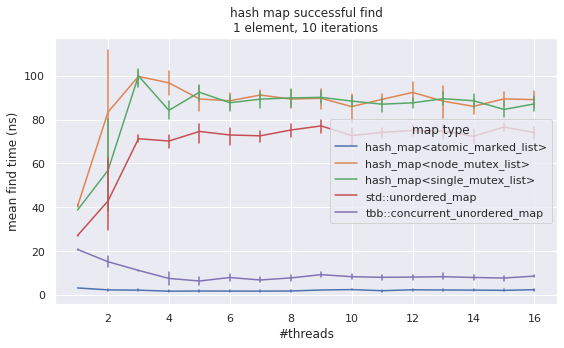

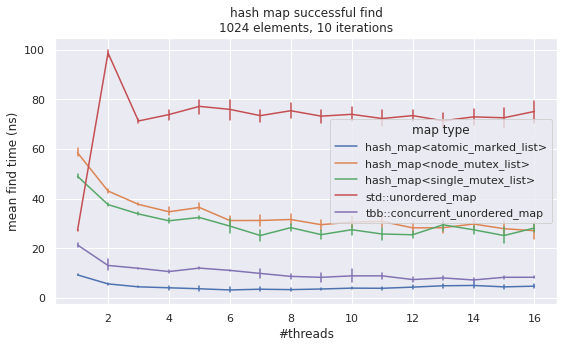

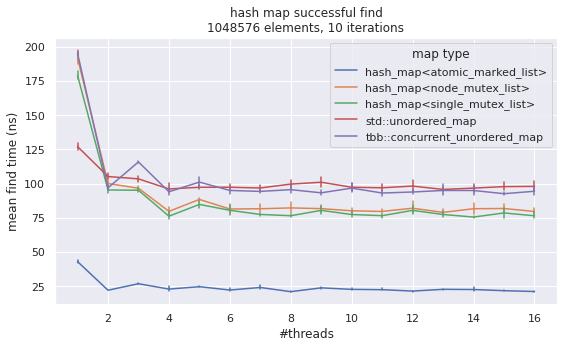

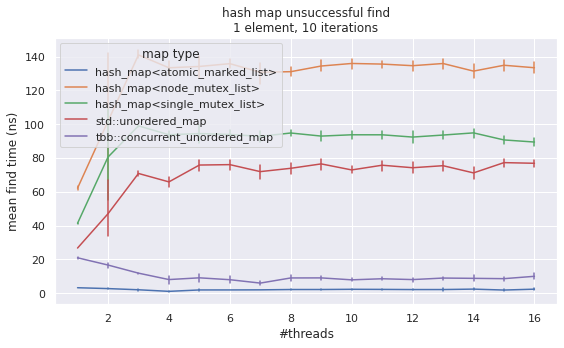

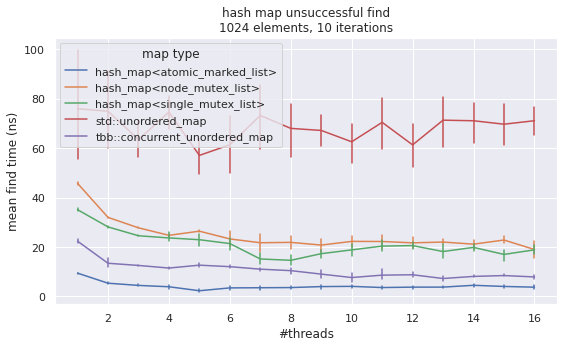

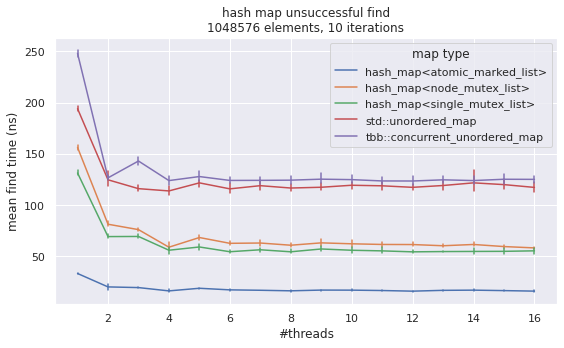

In [5]:
def plot_02(df, name):
    """
    hash map by #threads
    """
    num_iterations = df.groupby(["map_name", "num_elements", "num_queries", "num_threads"])["benchmark_name"].count()[0]

    for num_elements in (2**0, 2**10, 2**20):
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(data=df[df["num_elements"] == num_elements], x="num_threads", y="time_per_num_queries", hue="map type", err_style="bars")
        
        ax.set_title(f"{name}\n{num_elements} element{'s' if num_elements > 1 else ''}, {num_iterations} iterations")
        ax.set_xlabel("#threads")
        ax.set_ylabel("mean find time (ns)")
        
        fig.tight_layout()
        plt.savefig(f"02-{name.replace(' ', '-')}_{num_elements}-elements.png", dpi=300)

plot_02(get_data("H*_successful_find.csv"), "hash map successful find")
plot_02(get_data("H*_unsuccessful_find.csv"), "hash map unsuccessful find")

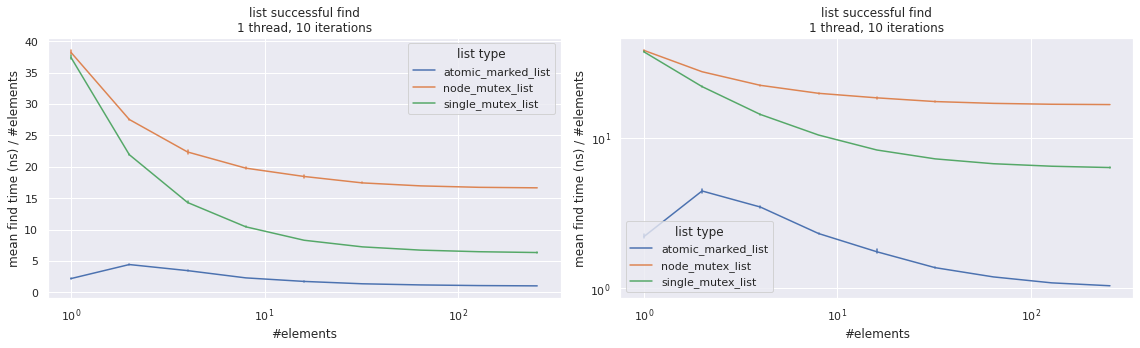

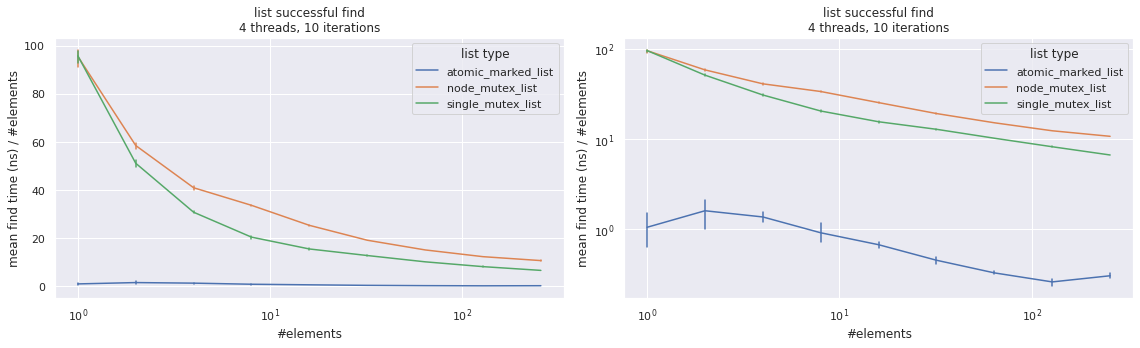

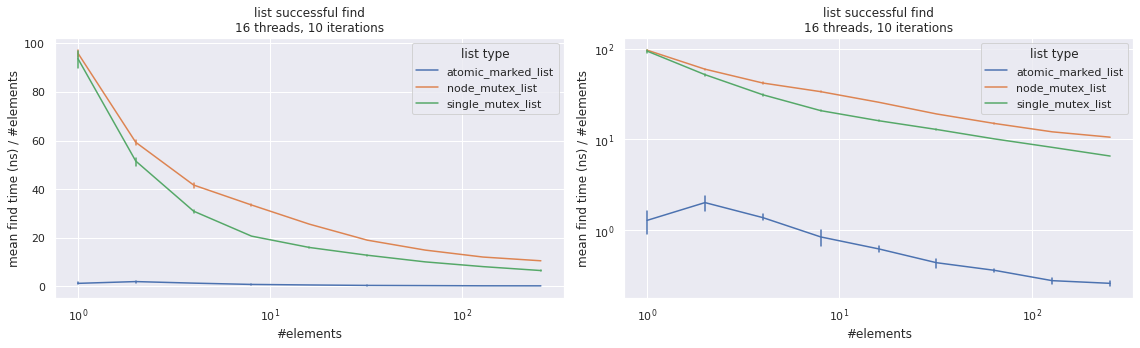

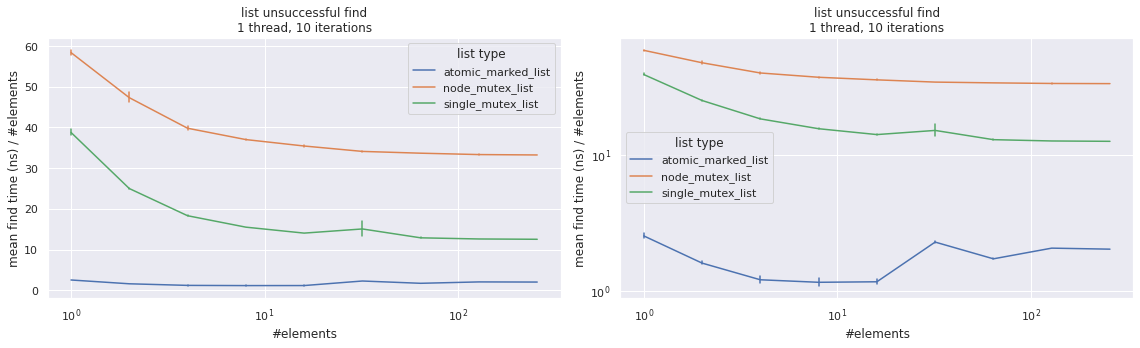

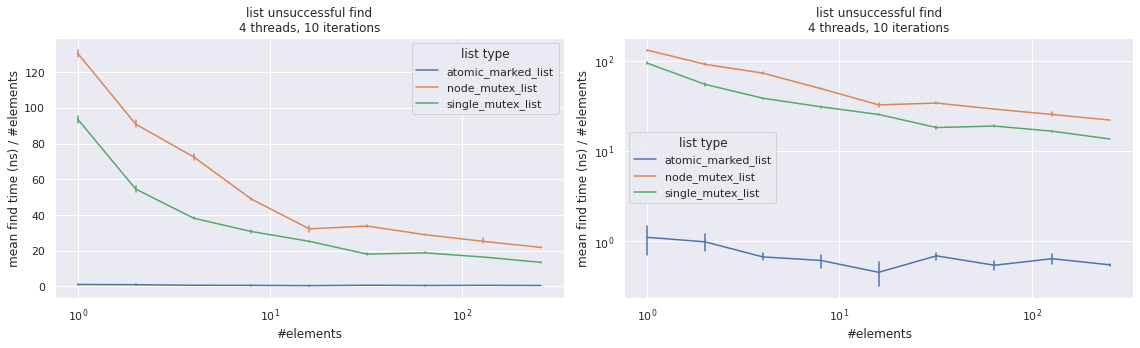

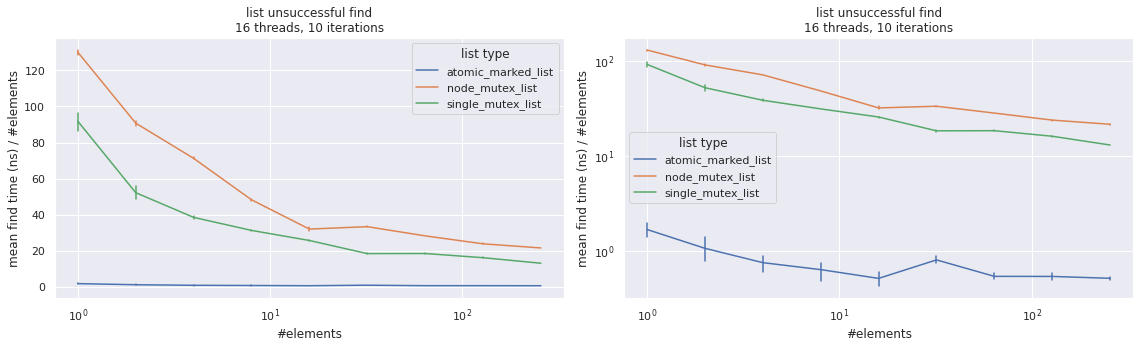

In [6]:
def plot_03(df, name):
    """
    list by #elements
    """
    num_iterations = df.groupby(["list_name", "num_elements", "num_queries", "num_threads"])["benchmark_name"].count()[0]
    for num_threads in (1, 4, 16):
        fig, axes = plt.subplots(figsize=(16, 5), ncols=2)

        for ax in axes:
            sns.lineplot(data=df[df["num_threads"] == num_threads], x="num_elements", y="time_per_num_queries_and_num_elements", hue="list type", err_style="bars", legend="full", ax=ax)

            ax.set_title(f"{name}\n{num_threads} thread{'s' if num_threads > 1 else ''}, {num_iterations} iterations")
            ax.set_xlabel("#elements")
            ax.set_ylabel("mean find time (ns) / #elements")
            ax.set_xscale("log")
        axes[1].set_yscale("log")

        fig.tight_layout()
        plt.savefig(f"03-{name.replace(' ', '-')}_{num_threads}-threads.png", dpi=300)

plot_03(get_data("L*_successful_find.csv"), "list successful find")
plot_03(get_data("L*_unsuccessful_find.csv"), "list unsuccessful find")

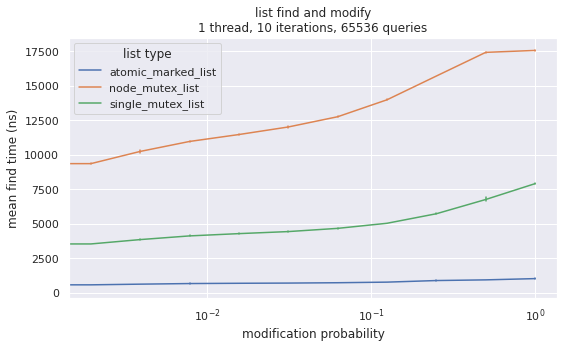

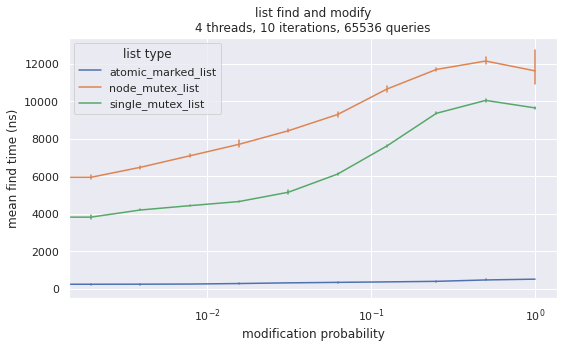

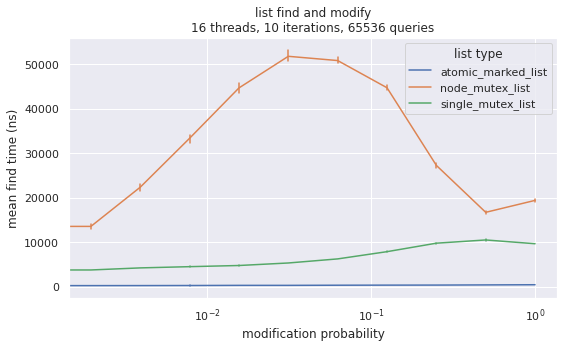

In [9]:
def plot_04(df, name):
    """
    list find/modify
    """
    num_modification_probabilities = len(df["modification_probability"].unique())
    num_iterations = df.groupby(["list_name", "num_elements", "num_queries", "num_threads"])["benchmark_name"].count()[0] // num_modification_probabilities
    num_queries = df["num_queries"][0]
    for num_threads in (1, 4, 16):
        fig, ax = plt.subplots(figsize=(8, 5))
        
        sns.lineplot(data=df[df["num_threads"] == num_threads], x="modification_probability", y="time_per_num_queries", hue="list type", err_style="bars")
        
        ax.set_title(f"{name}\n{num_threads} thread{'s' if num_threads > 1 else ''}, {num_iterations} iterations, {num_queries} queries")
        ax.set_xlabel("modification probability")
        ax.set_ylabel("mean find time (ns)")
        ax.set_xscale("log")

        fig.tight_layout()
        plt.savefig(f"04-{name.replace(' ', '-')}_{num_threads}-threads.png", dpi=300)

plot_04(get_data("L*_find_and_modifiy.csv"), "list find and modify")

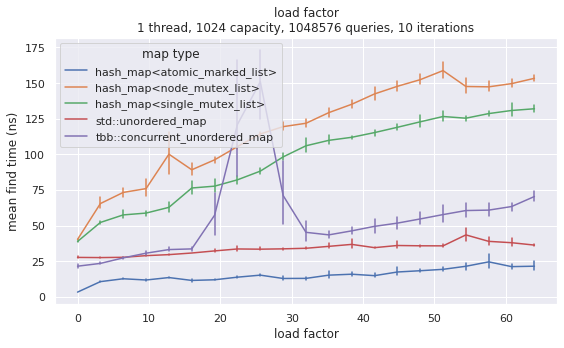

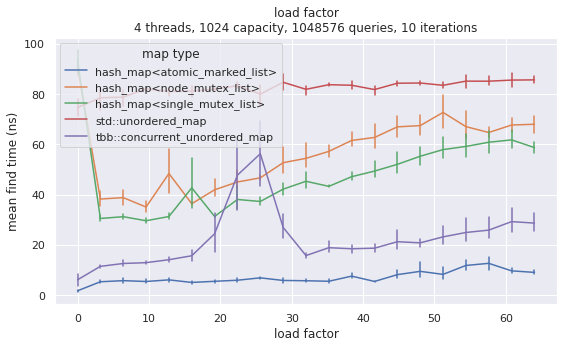

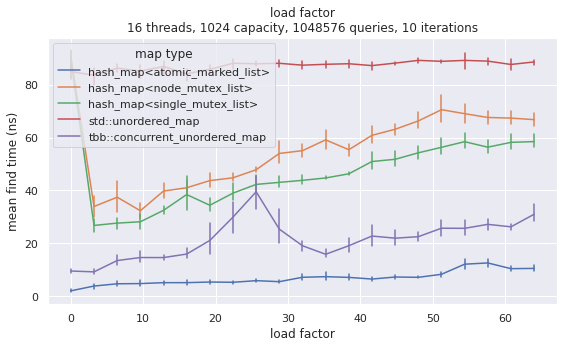

In [8]:
def plot_05(df, name):
    """
    hash map load factor
    """
    num_load_factors = len(df["load_factor"].unique())
    num_iterations = df.groupby(["map_name", "num_elements", "num_queries", "num_threads"])["benchmark_name"].count()[0]
    num_queries = df["num_queries"][0]
    capacity = df["capacity"][0]

    for num_threads in (1, 4, 16):
        fig, ax = plt.subplots(figsize=(8, 5))
        
        sns.lineplot(data=df[df["num_threads"]==num_threads], x="load_factor", y="time_per_num_queries", hue="map type", err_style="bars")
        
        ax.set_title(f"{name}\n{num_threads} thread{'s' if num_threads > 1 else ''}, {capacity} capacity, {num_queries} queries, {num_iterations} iterations")
        ax.set_xlabel("load factor")
        ax.set_ylabel("mean find time (ns)")
        
        fig.tight_layout()
        plt.savefig(f"05-{name.replace(' ', '-')}_{num_threads}-threads.png", dpi=300)
        plt.show()

plot_05(get_data("H*_load_factor.csv"), "load factor")

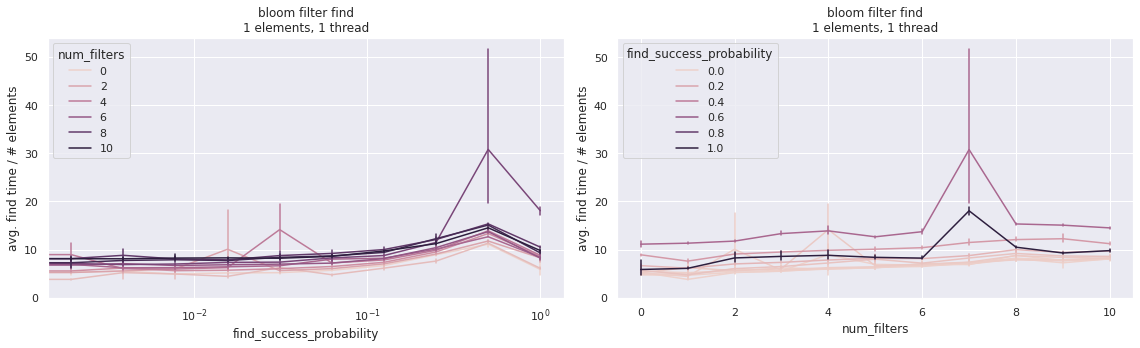

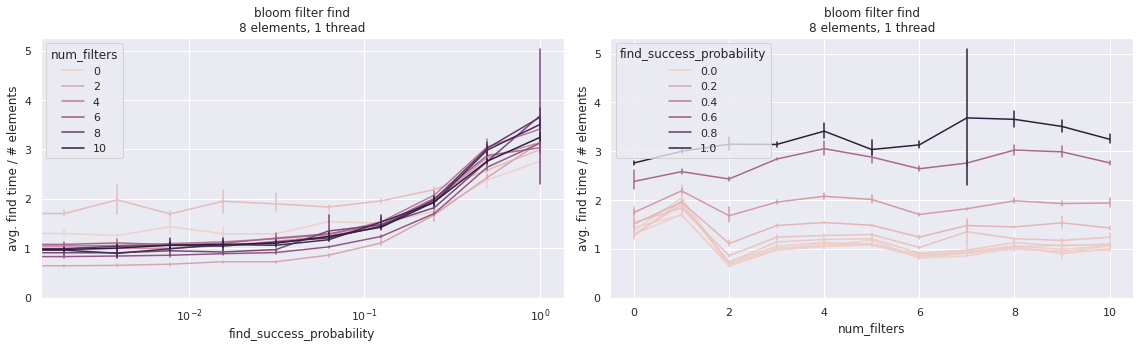

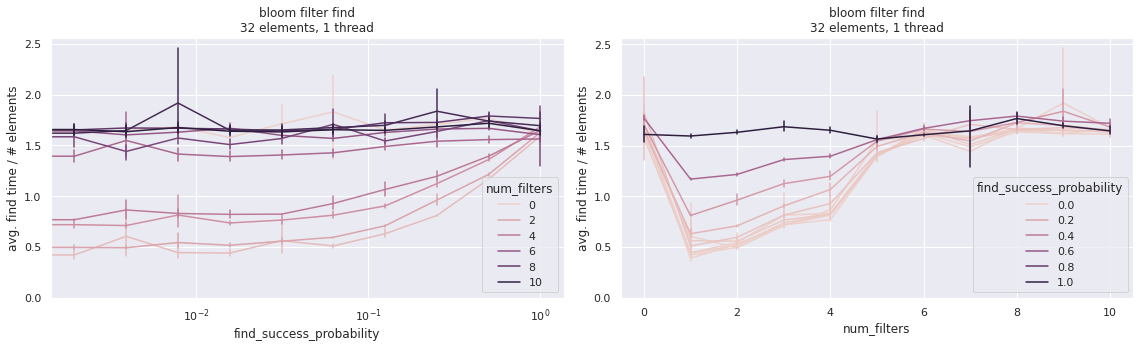

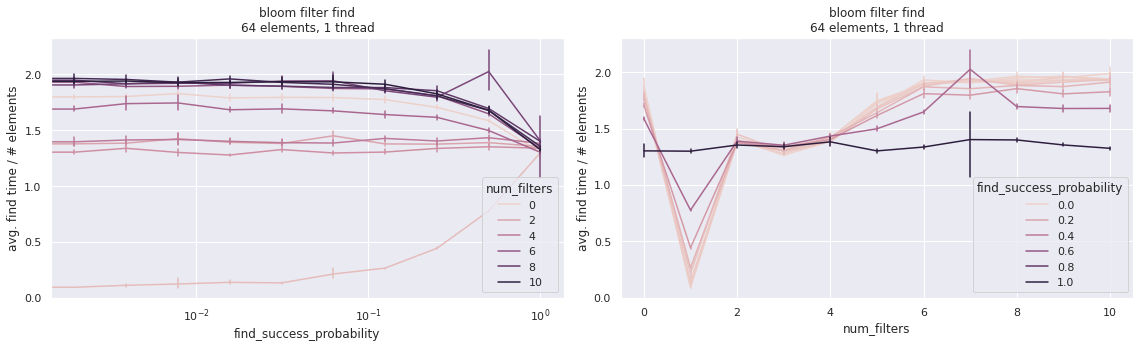

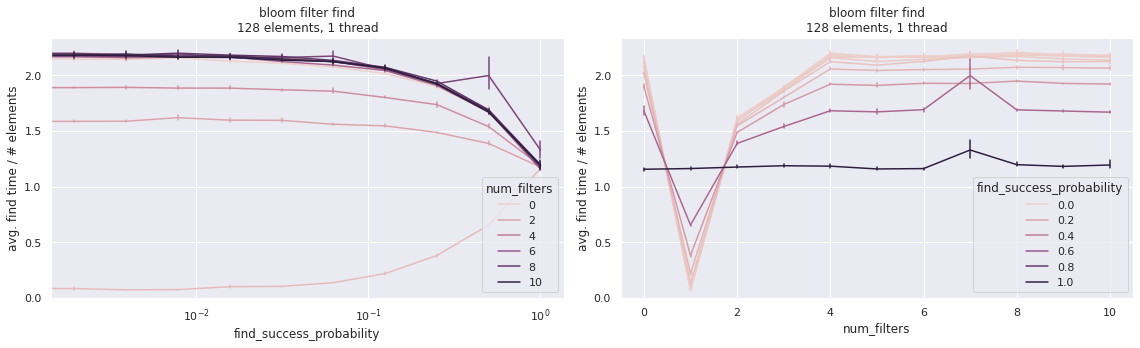

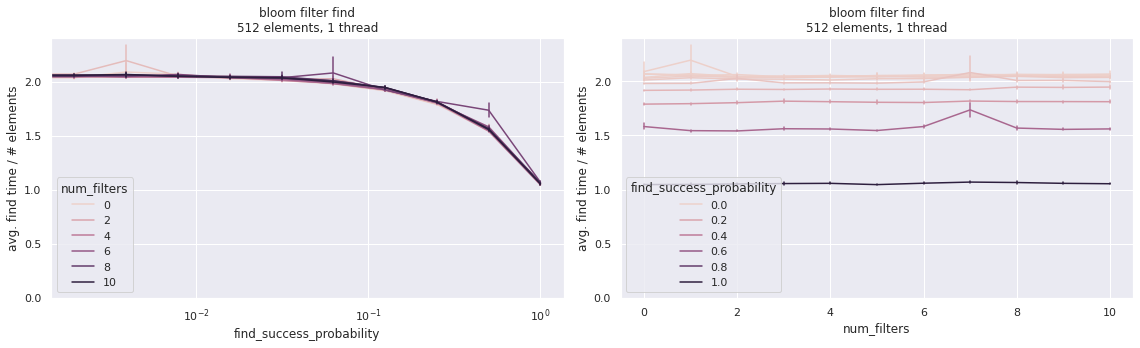

In [105]:
def plot_06(df):
    num_threads = 1
    for num_elements in (1, 8, 32, 64, 128, 512):
        data = df[(df["num_threads"] == num_threads) & (df["num_elements"] == num_elements)]
            
        fig, axes = plt.subplots(figsize=(16, 5), ncols=2)

        sns.lineplot(data=data, x="find_success_probability", y="time_per_num_queries_and_num_elements", hue="num_filters", err_style="bars", ax=axes[0])
        sns.lineplot(data=data, x="num_filters", y="time_per_num_queries_and_num_elements", hue="find_success_probability", err_style="bars", ax=axes[1])

        axes[0].set_xscale("log")
        for ax in axes:
            ax.set_ylim((0, None))
            ax.set_title(f"bloom filter find\n{num_elements} elements, {num_threads} thread")
            ax.set_ylabel("avg. find time / # elements")

        fig.tight_layout()
        plt.savefig(f"06-bloom-filter_{num_elements}-elements.png", dpi=300)
        plt.show()

plot_06(get_data("BF*_find.csv"))

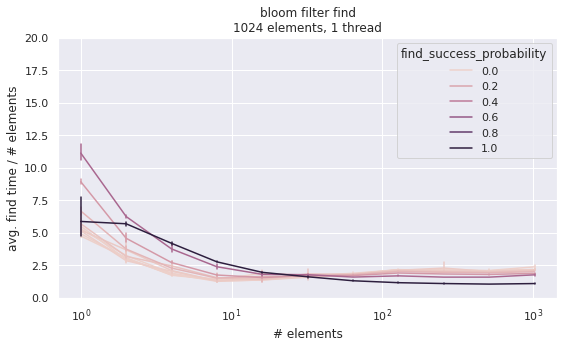

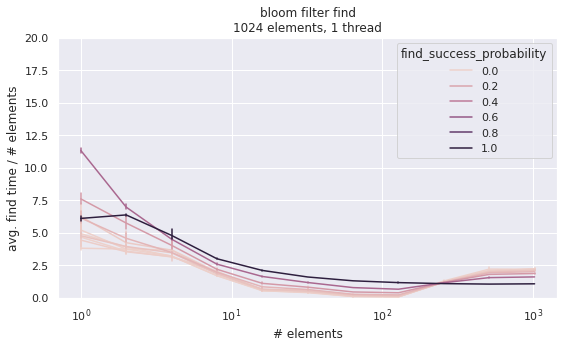

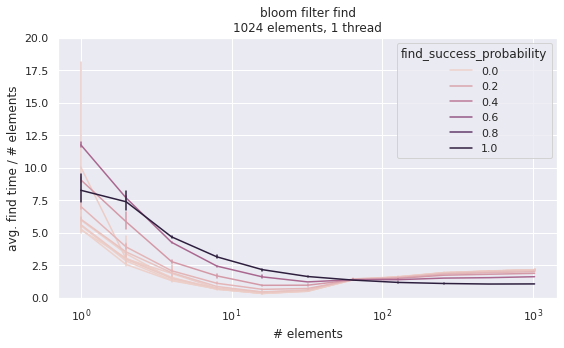

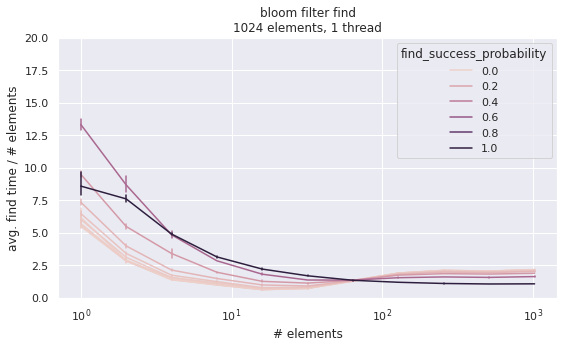

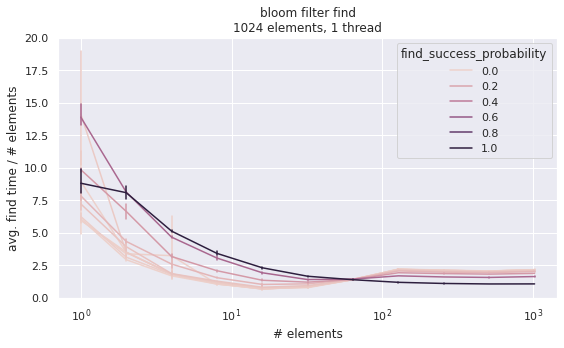

In [106]:
def plot_07(df):
    num_threads = 1
    for num_filters in (0, 1, 2, 3, 4):
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(data=df[(df["num_threads"] == num_threads) & (df["num_filters"] == num_filters)], x="num_elements", y="time_per_num_queries_and_num_elements", hue="find_success_probability", err_style="bars")

        ax.set_ylim((0, 20))
        ax.set_title(f"bloom filter find\n{num_elements} elements, {num_threads} thread")
        ax.set_xlabel("# elements")
        ax.set_ylabel("avg. find time / # elements")
        ax.set_xscale("log")
        
        fig.tight_layout()
        plt.savefig(f"07-bloom-filter_{num_filters}-filters.png", dpi=300)
        plt.show()

plot_07(get_data("BF*_find.csv"))

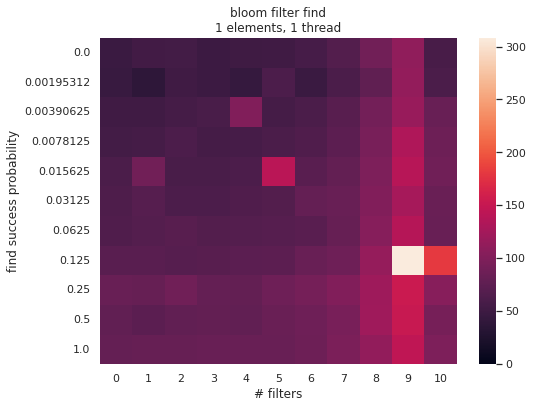

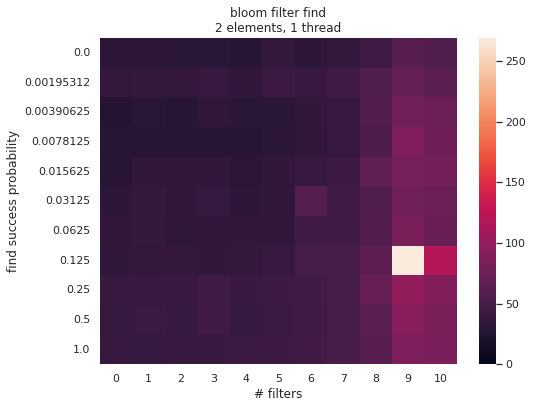

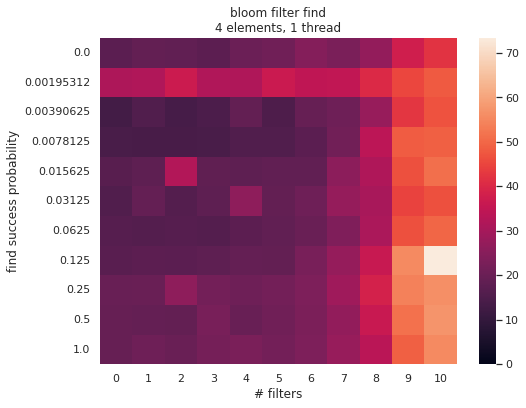

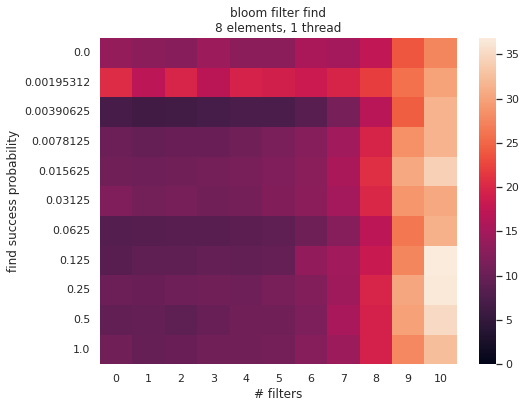

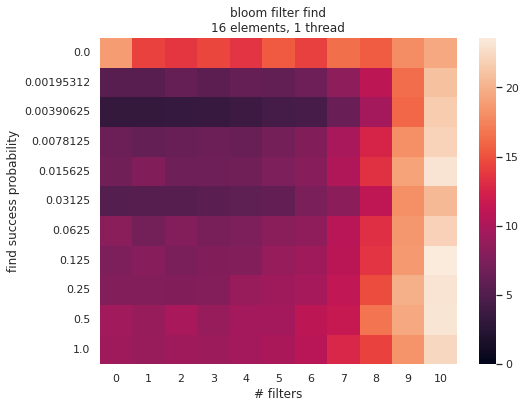

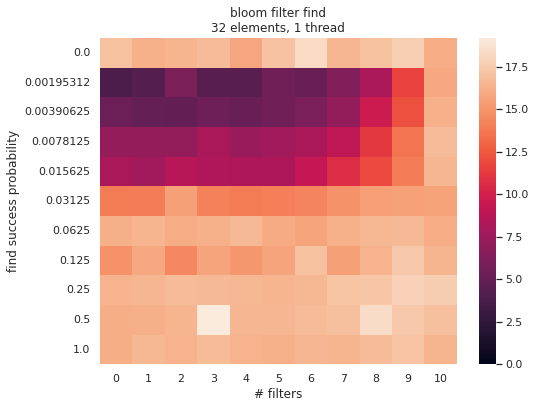

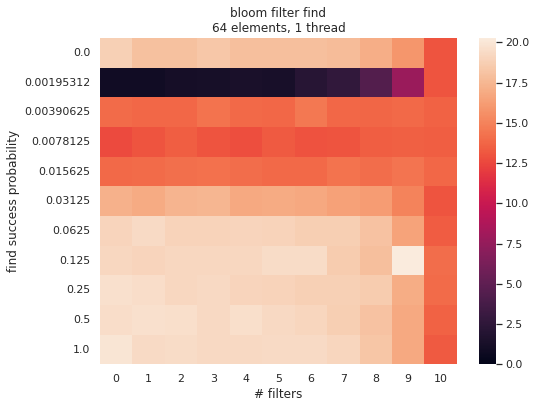

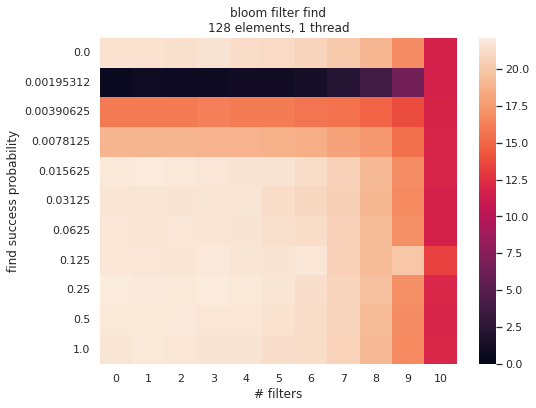

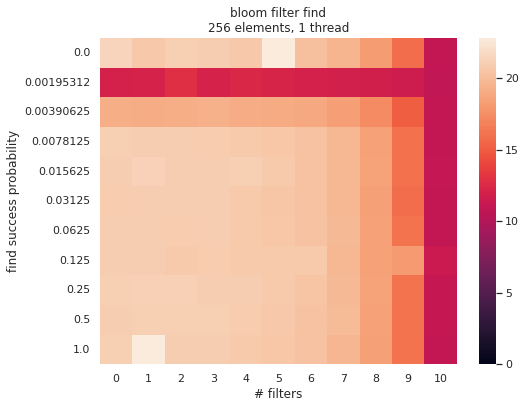

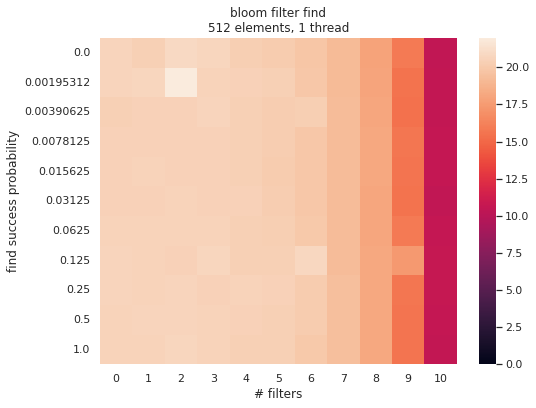

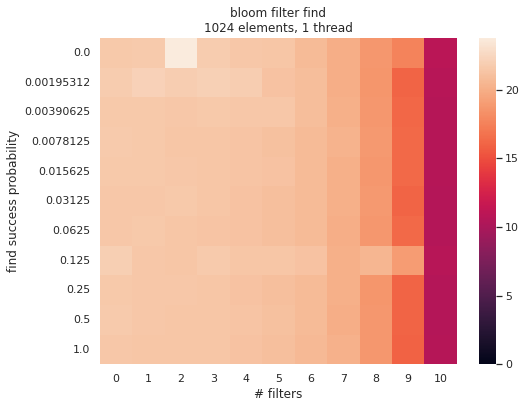

In [107]:
def plot_08(df):
    num_filters_v = list(sorted(df["num_filters"].unique()))
    num_elements_v = list(sorted(df["num_elements"].unique()))
    find_success_probability_v = list(sorted(df["find_success_probability"].unique()))


    for num_elements in num_elements_v:

        t = np.zeros((len(num_filters_v),len(find_success_probability_v)))

        for i, num_filters in enumerate(num_filters_v):
            for j, find_success_probability in enumerate(find_success_probability_v):
                t[i, j] = df.loc[(df["num_elements"] == num_elements) & (np.abs(df["find_success_probability"] - find_success_probability) < 1e-6) & (df["num_threads"] == 1) & (df["num_filters"] == num_filters), "time_per_num_queries_and_num_elements"].sum()

        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(t, xticklabels=num_filters_v, yticklabels=find_success_probability_v, vmin=0)
        ax.set_xlabel("# filters")
        ax.set_ylabel("find success probability")
        ax.set_title(f"bloom filter find\n{num_elements} elements, {num_threads} thread")
        plt.show()
        
plot_08(get_data("BF*_find.csv"))